In [1]:
import pandas as pd

#We will use numpy to calculate lograthims
import numpy as np

#We will use seaborn and matplotlib for plotting
import seaborn as sns
from matplotlib import pyplot as plt

###NOTE - you will probably get an error saying package seaborn not found. So you need to install it!
###How do you install packages???? After you install, refresh this page and try loading it again.

#This line will allow our plots to show in this notebook
%matplotlib inline

Let's load up the clean dataframe that we made with filtered counts and our length column. We saved this file as a comma separated file (csv), so we will load it with read_csv (instead of read_table that is used for tab separated files). There aren't any comments at the top of the file, so we don't need to use comment = "#". Let's just set the first column as the index with index_col=0. Take a look at the shape and the first 5 rows of the dataframe. 

In [2]:
feature_counts_dir = "/home/ucsd-train40/cmm262/featurecounts/"

counts = pd.read_csv(feature_counts_dir+"tardbp_counts_with_length.csv", index_col=0)
print counts.shape
counts.head()

(16582, 5)


,Length,NT_shRNA_hepg2_Rep1,NT_shRNA_hepg2_Rep2,TARDBP_shRNA_hepg2_Rep1,TARDBP_shRNA_hepg2_Rep2
Geneid,,,,,
ENSG00000227232.4,2073,61,92,69,58
ENSG00000237683.5,2661,23,21,17,28
ENSG00000239906.1,323,11,2,5,7
ENSG00000241860.2,6195,26,32,35,35
ENSG00000228463.4,3954,77,69,63,66


First lets make a list of the data columns and call them data_cols:

In [3]:
data_cols = counts.columns[1:]

Now take those data columns and divide them by the length in kilobases (length / 1000)

In [4]:
counts[data_cols].divide((counts['Length']/1000), axis=0)

,NT_shRNA_hepg2_Rep1,NT_shRNA_hepg2_Rep2,TARDBP_shRNA_hepg2_Rep1,TARDBP_shRNA_hepg2_Rep2
Geneid,,,,
ENSG00000227232.4,2.942595e+01,4.438013e+01,3.328509e+01,2.797877e+01
ENSG00000237683.5,8.643367e+00,7.891770e+00,6.388576e+00,1.052236e+01
ENSG00000239906.1,3.405573e+01,6.191950e+00,1.547988e+01,2.167183e+01
ENSG00000241860.2,4.196933e+00,5.165456e+00,5.649718e+00,5.649718e+00
ENSG00000228463.4,1.947395e+01,1.745068e+01,1.593323e+01,1.669196e+01
ENSG00000237094.7,5.532101e+00,6.405590e+00,6.551172e+00,5.968846e+00
ENSG00000225972.1,2.373656e+03,2.311828e+03,1.701613e+03,3.110215e+03
ENSG00000225630.1,2.562261e+03,2.256705e+03,2.121648e+03,2.807471e+03
ENSG00000237973.1,4.689566e+03,4.946857e+03,5.309138e+03,7.150356e+03


Save the resulting counts as rpk (reads per kilobase) 

In [5]:
rpk = counts[data_cols].divide((counts['Length']/1000), axis=0)

Now we need to divide each value by the sum of the column (total counts). Scale the answer by 10 ^ 6 to get transcripts per million. 

In [6]:
sums_per_million = rpk.sum(axis=0)/(10**6)

In [7]:
tpm = rpk.divide(sums_per_million)
tpm.head()

,NT_shRNA_hepg2_Rep1,NT_shRNA_hepg2_Rep2,TARDBP_shRNA_hepg2_Rep1,TARDBP_shRNA_hepg2_Rep2
Geneid,,,,
ENSG00000227232.4,1.915979,2.881630,2.267504,1.831513
ENSG00000237683.5,0.562786,0.512418,0.435213,0.688802
ENSG00000239906.1,2.217432,0.402047,1.054546,1.418655
ENSG00000241860.2,0.273270,0.335396,0.384880,0.369835
ENSG00000228463.4,1.267985,1.133084,1.085431,1.092669


In [8]:
#Now let's make a function out of this:

def counts_to_tpm(counts_matrix):
    data_cols = counts_matrix.columns[1:]
    rpk = counts_matrix[data_cols].divide((counts_matrix['Length']/1000), axis=0)
    sums_per_million = rpk.sum(axis=0)/(10**6)
    tpm = rpk.divide(sums_per_million)
    
    return tpm


In [9]:
tpm_from_function = counts_to_tpm(counts)

In [15]:
tpm.head()

,NT_shRNA_hepg2_Rep1,NT_shRNA_hepg2_Rep2,TARDBP_shRNA_hepg2_Rep1,TARDBP_shRNA_hepg2_Rep2
Geneid,,,,
ENSG00000227232.4,1.915979,2.881630,2.267504,1.831513
ENSG00000237683.5,0.562786,0.512418,0.435213,0.688802
ENSG00000239906.1,2.217432,0.402047,1.054546,1.418655
ENSG00000241860.2,0.273270,0.335396,0.384880,0.369835
ENSG00000228463.4,1.267985,1.133084,1.085431,1.092669


In [12]:
#We can also make a function for FPKM, which is a slightly different way of normalizing reads

def counts_to_fpkm(counts_w_length):
    rpm = counts_w_length[data_cols].divide((counts_w_length[data_cols].sum(axis=0)) / (10**6))
    fpkm = rpm[data_cols].divide((counts_w_length['Length']/1000), axis=0)
    return fpkm

In [14]:
counts_to_fpkm(counts).head()

,NT_shRNA_hepg2_Rep1,NT_shRNA_hepg2_Rep2,TARDBP_shRNA_hepg2_Rep1,TARDBP_shRNA_hepg2_Rep2
Geneid,,,,
ENSG00000227232.4,1.055163,1.460232,1.117210,0.947973
ENSG00000237683.5,0.309936,0.259662,0.214432,0.356517
ENSG00000239906.1,1.221179,0.203733,0.519580,0.734282
ENSG00000241860.2,0.150495,0.169958,0.189632,0.191423
ENSG00000228463.4,0.698302,0.574177,0.534797,0.565554


In [17]:
save_dir = '/home/ucsd-train40/projects/tardbp_shrna/featurecounts/'
tpm.to_csv(save_dir+"tardbp_shrna_tpm.csv")

(array([  1.65660000e+04,   4.00000000e+00,   1.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([     0.        ,   9622.35737194,  19244.71474388,  28867.07211582,
         38489.42948776,  48111.7868597 ,  57734.14423164,  67356.50160358,
         76978.85897552,  86601.21634746,  96223.5737194 ]),
 <a list of 10 Patch objects>)

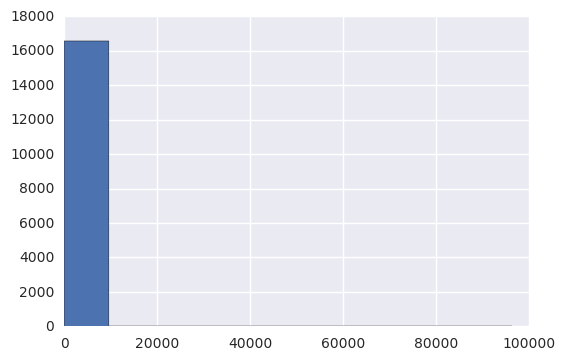

In [18]:
plt.hist(tpm['TARDBP_shRNA_hepg2_Rep1'])

(array([  5.81100000e+03,   5.44200000e+03,   3.76900000e+03,
          1.19900000e+03,   2.65000000e+02,   6.30000000e+01,
          1.30000000e+01,   4.00000000e+00,   7.00000000e+00,
          9.00000000e+00]),
 array([  0.        ,   1.65541178,   3.31082355,   4.96623533,
          6.6216471 ,   8.27705888,   9.93247065,  11.58788243,
         13.2432942 ,  14.89870598,  16.55411775]),
 <a list of 10 Patch objects>)

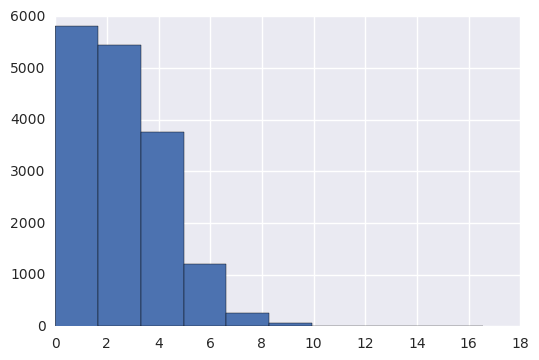

In [19]:
plt.hist(np.log2(tpm['TARDBP_shRNA_hepg2_Rep1'] + 1))

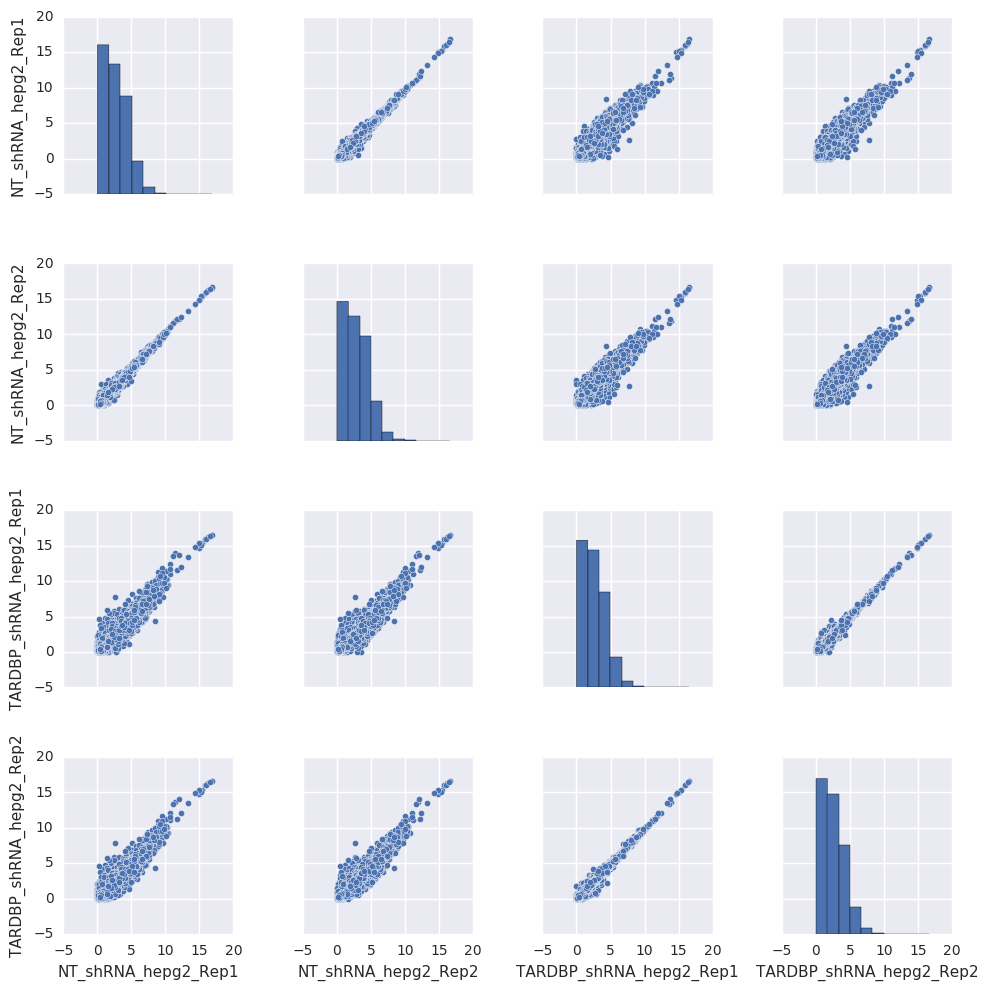

In [20]:
sns.pairplot(np.log2(tpm+1))

In [21]:
log2_tpm = np.log2(tpm+1)

In [22]:
log2_tpm.corr()

,NT_shRNA_hepg2_Rep1,NT_shRNA_hepg2_Rep2,TARDBP_shRNA_hepg2_Rep1,TARDBP_shRNA_hepg2_Rep2
NT_shRNA_hepg2_Rep1,1.000000,0.993149,0.953633,0.953689
NT_shRNA_hepg2_Rep2,0.993149,1.000000,0.959157,0.957747
TARDBP_shRNA_hepg2_Rep1,0.953633,0.959157,1.000000,0.994570
TARDBP_shRNA_hepg2_Rep2,0.953689,0.957747,0.994570,1.000000


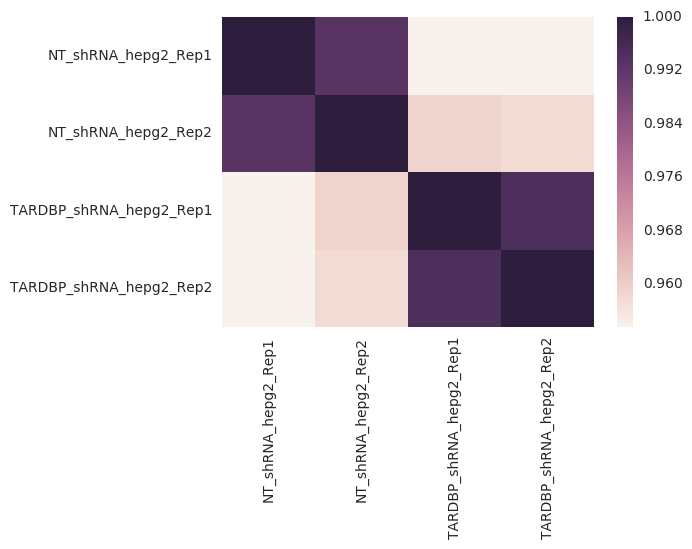

In [23]:
sns.heatmap(log2_tpm.corr())

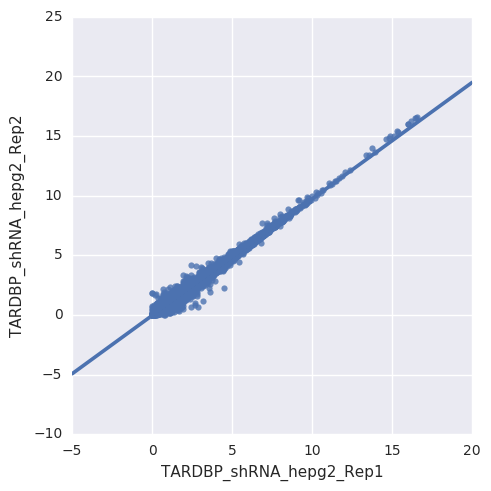

In [27]:
sns.lmplot('TARDBP_shRNA_hepg2_Rep1','TARDBP_shRNA_hepg2_Rep2',log2_tpm)

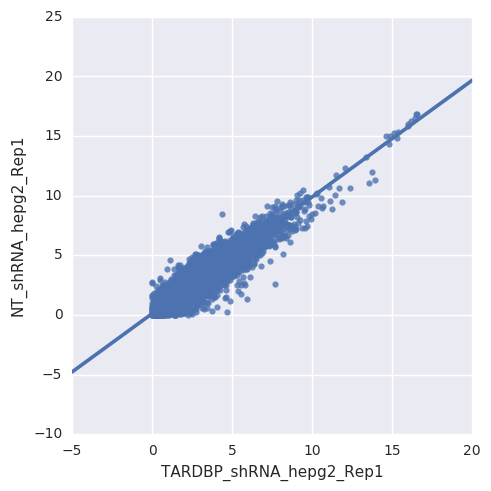

In [25]:
sns.lmplot('TARDBP_shRNA_hepg2_Rep1','NT_shRNA_hepg2_Rep1',log2_tpm)

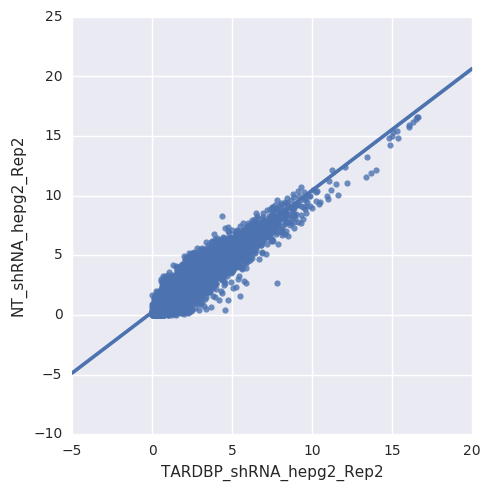

In [26]:
sns.lmplot('TARDBP_shRNA_hepg2_Rep2','NT_shRNA_hepg2_Rep2',log2_tpm)